# Notes on Chapter 3 of Statistical Rethinking 2nd Edition by Richard McElreath

In [145]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
from math import pi
tfd = tfp.distributions
tfm = tf.math
tfs = tfp.stats
import math
import pandas as pd
import numpy as np

In [2]:
%load_ext rpy2.ipython

### 3.1

In [3]:
%%R

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive <- Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

[1] 0.08683729


There's no advantage to using tensorflow if we're just using python as a calculator, so the python code is virtually identical to the R code:

In [4]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
Pr_Positive = Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

0.08683729433272395

### 3.2

In [5]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prob_p <- rep(1, 1000)
prob_data <- dbinom(6, size=9, prob=p_grid)
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

In [6]:
p_grid = tf.linspace(0., 1., 1000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)

### 3.3

In [7]:
%%R

samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)

In [8]:
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.4

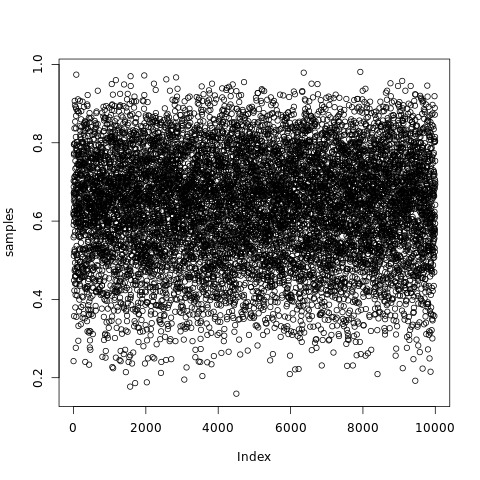

In [9]:
%%R

plot(samples)

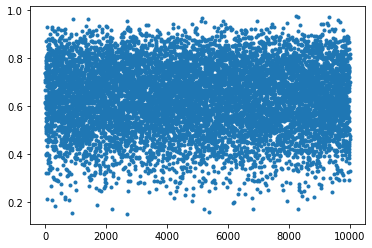

In [10]:
plt.plot(samples, '.');

### 3.5

R[write to console]: Loading required package: rstan

R[write to console]: Loading required package: StanHeaders

R[write to console]: Loading required package: ggplot2

R[write to console]: rstan (Version 2.21.1, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: dagitty

R[write to console]: rethinking (Version 2.01)

R[write to console]: 
Attaching package: ‘rethinking’


R[write to console]: The following object is masked from ‘package:stats’:

    rstudent




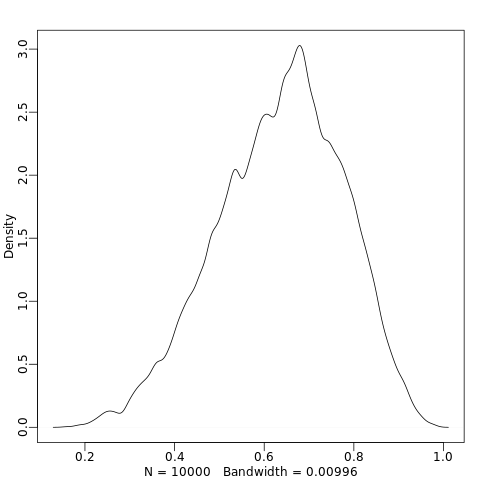

In [11]:
%%R

library(rethinking)
dens(samples)

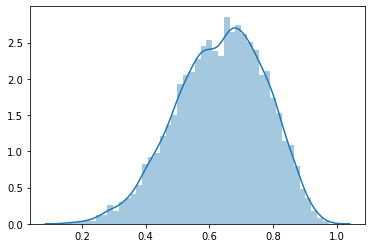

In [12]:
sns.distplot(samples)

### 3.6

In [13]:
%%R

sum(posterior[p_grid < 0.5])

[1] 0.1718746


In [14]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.17187457>

### 3.7

In [15]:
%%R

sum(samples < 0.5) / 1e4

[1] 0.1752


In [16]:
tf.reduce_sum(tf.cast(samples < 0.5, tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1714>

### 3.8

In [17]:
%%R

sum(samples > 0.5 & samples < 0.75) / 1e4

[1] 0.602


In [18]:
tf.reduce_sum(tf.cast(tf.logical_and(samples > 0.5, samples < 0.75), tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.604>

### 3.9

In [19]:
%%R

quantile(samples, 0.8)

      80% 
0.7607608 


In [20]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7607607>

### 3.10

In [21]:
%%R

quantile(samples, c(0.1, 0.8))

      10%       80% 
0.4463463 0.7607608 


In [22]:
tfp.stats.percentile(samples, (10, 80))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44944945, 0.7607607 ], dtype=float32)>

### 3.11

In [23]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(3, size=3, prob=p_grid)
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample(p_grid, size=1e4, replace=TRUE, prob=posterior)

In [24]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(3, probs=p_grid).prob(3)
posterior = likelihood * prior
posterior = posterior / tfm.reduce_sum(posterior)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

### 3.12

In [25]:
%%R

PI(samples, prob=0.5)

      25%       75% 
0.7094595 0.9309309 


Since we don't have a python version of the author's library (yet), we have to write our own PI function.

In [26]:
def PI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantile_indexes = tf.cast(
        n_quantiles * tf.constant([(1 - prob)/2, (1 + prob)/2]), tf.int32)
    return tf.gather(all_quantiles, quantile_indexes)

PI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7067067, 0.9309309], dtype=float32)>

### 3.13

In [27]:
%%R

HPDI(samples, prob=0.5)

     |0.5      0.5| 
0.8408408 0.9979980 


Again, we don't have a python version of the author's library, so we have to reimplement the HPDI function.

In [28]:
def HPDI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantiles_per_bin = int(prob * n_quantiles)
    bin_widths = (all_quantiles[quantiles_per_bin:] - 
                  all_quantiles[:-quantiles_per_bin])
    smallest_bin = tfm.argmin(bin_widths)
    return tf.gather(all_quantiles,
                     [smallest_bin, smallest_bin + quantiles_per_bin])

HPDI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8428428, 1.       ], dtype=float32)>

### 3.14

In [29]:
%%R

p_grid[which.max(posterior)]

[1] 1


In [30]:
p_grid[tfm.argmax(posterior)]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

### 3.15

In [31]:
%%R
chainmode(samples, adj=0.01)

[1] 0.9859628


This is again one of the author's functions that we don't have a tensorflow equivalent for.  Unfortunately we also don't seem to have a kernel density estimator in tensorflow (on which this function depends).  Rather than using a non-tensorflow implementation of a KDE (e.g. from scipy), we implement a tensorflow version here.

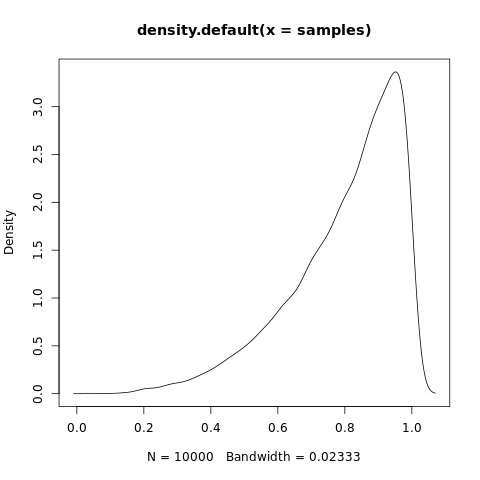

In [32]:
%%R

plot(density(samples), adjust=0.01)

In [33]:
@tf.function()
def kde(samples, adjust=1., n=512):
    quartiles = tfp.stats.quantiles(samples, 4)
    sd = tfp.stats.stddev(samples)
    iqr = quartiles[3]-quartiles[1]
    # Silverman's (1986) rule of thumb:
    bw = adjust*0.9*samples.shape[0]**(1./5)*tf.minimum(iqr/1.34,sd)
    minx = quartiles[0] - 2*bw
    maxx = quartiles[4] + 2*bw
    xs = tf.linspace(minx, maxx, n)
    binned_samples = tf.cast(tf.histogram_fixed_width(
        samples, [minx, maxx], n), dtype=samples.dtype)
    kernels = tfd.Normal(loc=xs,scale=bw).prob(xs[:,tf.newaxis])
    ys = (tf.tensordot(binned_samples, kernels, [[0],[1]]) / samples.shape[0])
    return xs,ys

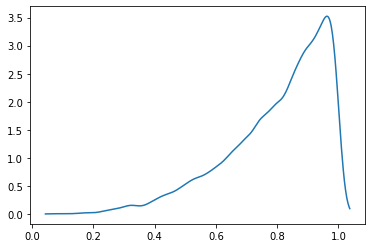

In [34]:
xs,ys = kde(samples, adjust=0.02)
plt.plot(xs,ys)

Now we can implement the chainmode function, and finally the code in the solution.

In [35]:
def chainmode(samples, *args, **nargs):
    xs,ys = kde(samples, *args, **nargs)
    return xs[tfm.argmax(ys)]

In [36]:
chainmode(samples, adjust=0.02)

<tf.Tensor: shape=(), dtype=float32, numpy=0.96309966>

### 3.16

In [37]:
%%R

c(mean(samples),median(samples))

[1] 0.8006877 0.8428428


In [38]:
tfm.reduce_mean(samples), tfp.stats.percentile(samples, 50)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.80046064>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8428428>)

### 3.17

In [39]:
%%R

sum(posterior*abs(0.5 - p_grid))

[1] 0.3128752


In [40]:
tfm.reduce_sum(posterior*abs(0.5 - p_grid))

<tf.Tensor: shape=(), dtype=float32, numpy=0.31287518>

### 3.18

In [41]:
%%R

loss <- sapply(p_grid, function(d) sum(posterior*abs(d - p_grid)))

While tf.map_fn would be closer to sapply, it seems more natural to express it in a vectorized fashion in tensorflow.

In [42]:
loss = tfm.reduce_sum(posterior[:,tf.newaxis]*abs(
    p_grid[tf.newaxis,:] - p_grid[:,tf.newaxis]), axis=0)

### 3.19

In [43]:
%%R

p_grid[which.min(loss)]

[1] 0.8408408


In [44]:
p_grid[tf.argmin(loss)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8408408>

### 3.20

In [45]:
%%R

dbinom(0:2, size=2, prob=0.7)

[1] 0.09 0.42 0.49


In [46]:
tfd.Binomial(2, probs=0.7).prob(tf.range(3.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000002, 0.48999998], dtype=float32)>

### 3.21

In [47]:
%%R

rbinom(1, size=2, prob=0.7)

[1] 2


In [48]:
tfd.Binomial(2, probs=0.7).sample(1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

### 3.22

In [49]:
%%R

rbinom(10, size=2, prob=0.7)

 [1] 2 2 2 1 2 2 2 1 1 1


In [50]:
tfd.Binomial(2, probs=0.7).sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 1., 1., 2., 1., 2., 2., 1., 1., 2.], dtype=float32)>

### 3.23

In [51]:
%%R

dummy_w <- rbinom(1e5, size=2, prob=0.7)
table(dummy_w)/1e5

dummy_w
      0       1       2 
0.08912 0.42288 0.48800 


In [52]:
num_tosses = 2
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
tf.reduce_sum(tf.one_hot(tf.cast(dummy_w, tf.int32), num_tosses+1), axis=0) / (
    len(dummy_w) )

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09063, 0.42236, 0.48701], dtype=float32)>

### 3.23

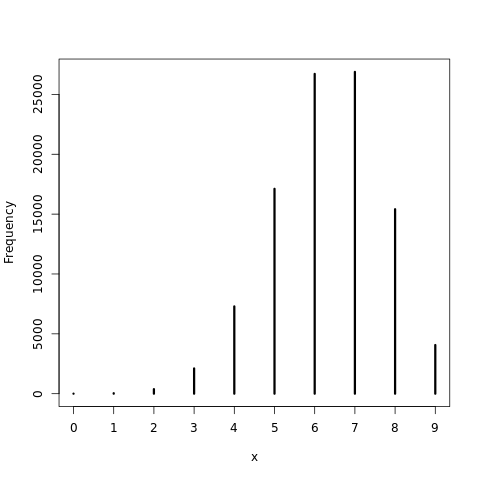

In [53]:
%%R

dummy_w <- rbinom(1e5, size=9, prob=0.7)
simplehist(dummy_w)

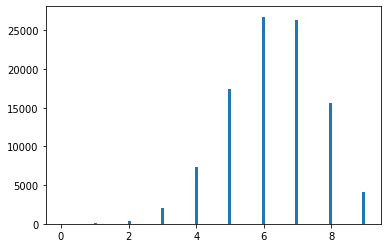

In [54]:
num_tosses = 9
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
plt.hist(dummy_w, bins=100);

### 3.25

In [55]:
%%R

w <- rbinom(1e4, size=9, prob=0.6)

In [56]:
w = tfd.Binomial(9, probs=0.6).sample(1e4)

### 3.26

In [57]:
%%R

w <- rbinom(1e4, size=9, prob=samples)

In [58]:
w = tfd.Binomial(9, probs=samples).sample()

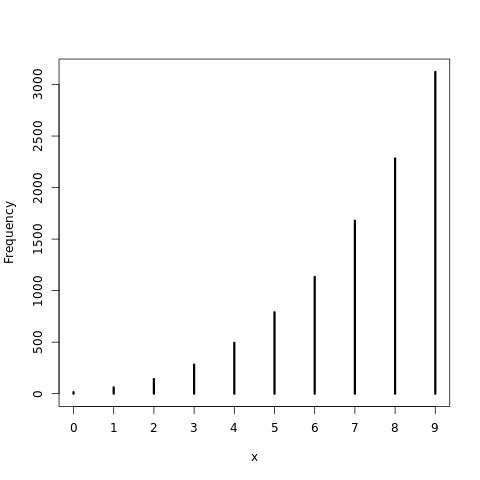

In [59]:
%%R

simplehist(w)

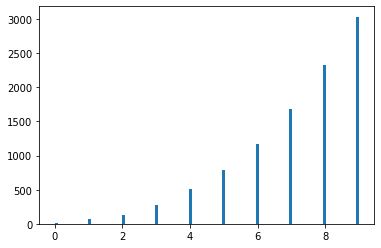

In [60]:
plt.hist(w, bins=100);

### Practice

### 3.27

*NB:* Increased number of samples from $10^4$ to $10^6$ to reduce sampling noise and thus make it easier to compare implementations.

In [61]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(6, size=9, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)
set.seed(100)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)

In [62]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
tf.random.set_seed(100)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))

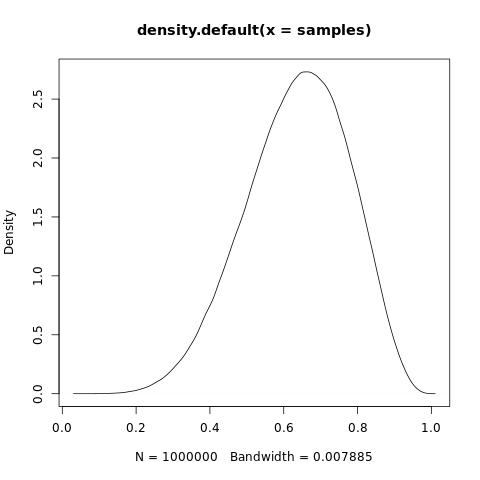

In [63]:
%%R

plot(density(samples))

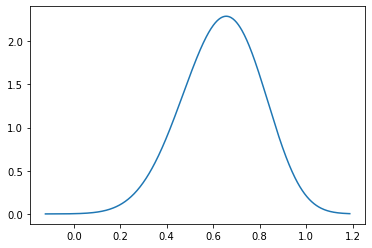

In [64]:
xs,ys = kde(samples, adjust=0.05)
plt.plot(xs,ys);

### 3E1

In [65]:
%%R

sum(samples<0.2)/length(samples)

[1] 0.000871


In [66]:
tf.reduce_sum(tf.cast(samples < 0.2, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.000879>

### 3E2

In [67]:
%%R

sum(samples > 0.8)/length(samples)

[1] 0.120409


In [68]:
tf.reduce_sum(tf.cast(samples > 0.8, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.120794>

### 3E3

In [69]:
%%R

sum((samples > 0.2) & (samples < 0.8))/length(samples)

[1] 0.87872


In [70]:
tf.reduce_sum(
    tf.cast(tf.logical_and(samples > 0.2, samples < 0.8), tf.float32)
    )/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.878327>

### 3E4

In [71]:
%%R

quantile(samples, 0.2)

      20% 
0.5165165 


In [72]:
tfp.stats.percentile(samples, 20)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5165165>

### 3E5

In [73]:
%%R

quantile(samples, 0.8)

      80% 
0.7607608 


In [74]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7607607>

### 3E6

In [75]:
%%R

HPDI(samples, 0.66)

    |0.66     0.66| 
0.5135135 0.7857858 


In [76]:
HPDI(samples, 0.66)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5165165, 0.7887888], dtype=float32)>

### 3E7

In [77]:
%%R

quantile(samples, c(0.17, 0.83))

      17%       83% 
0.4984985 0.7747748 


In [78]:
tfp.stats.percentile(samples, [17, 83])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4984985, 0.7747748], dtype=float32)>

### 3M1

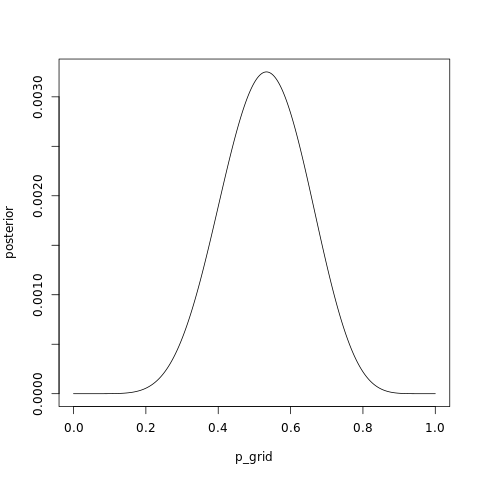

In [79]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

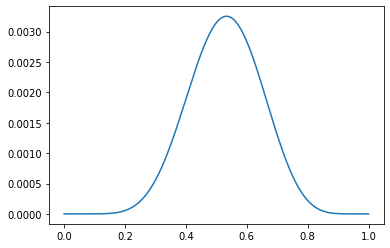

In [80]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

### 3M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [81]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.3293293 0.7167167 


In [82]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.33433434, 0.7207207 ], dtype=float32)>

### 3M3

In [83]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
sum(prediction_samples == 8) / length(prediction_samples)

[1] 0.146826


In [84]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.1475>

### 3M4

In [85]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
sum(prediction_samples == 6) / length(prediction_samples)

[1] 0.177008


In [86]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.1768>

### 3M5
#### 3M5.M1

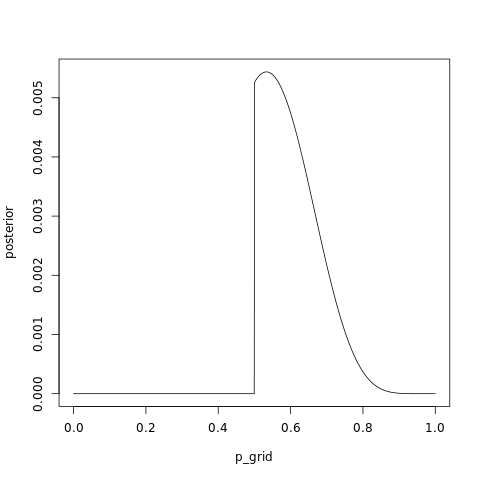

In [87]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- c(rep(0,500), rep(1,500))
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

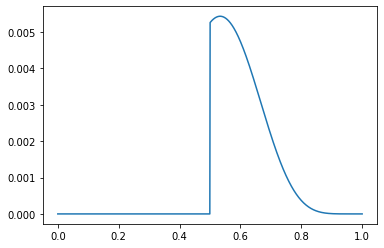

In [88]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.cast(p_grid > 0.5, p_grid.dtype)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

#### 3M5.M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [89]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.5005005 0.7117117 


In [90]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5005005, 0.7117117], dtype=float32)>

#### 3M5.M3

In [91]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
print(sum(prediction_samples == 8) / length(prediction_samples))
print(dbinom(8, size=15, prob=0.7))

[1] 0.157816
[1] 0.08113003


In [92]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))
ideal = tfd.Binomial(15, probs=0.7).prob(8)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.158, ideal 0.081


#### 3M5.M4

In [93]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
print(sum(prediction_samples == 6) / length(prediction_samples))
print(dbinom(6, size=9, prob=0.7))

[1] 0.232274
[1] 0.2668279


In [94]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))
ideal = tfd.Binomial(9, probs=0.7).prob(6)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.233, ideal 0.267


### 3M6

One way to do this would be to use the closed form version of the prior, because we do have it for this problem.  In general, however, we will need to numerically sample from the prior, so we'll use that approach here.

In [95]:
%%R

target_width <- 0.05
target_ci <- 0.99
power <- 0.5
samples_per_n <- 10000

interval_simulation <- function (n_tosses, p) {
    p_grid <- seq(from=0, to=1, length.out=10000)
    prior <- rep(1,length(p_grid))
    likelihood <- dbinom(rbinom(1,n_tosses,p), size=n_tosses, prob=p_grid)
    posterior <- likelihood*prior
    posterior <- posterior / sum(posterior)
    posterior_cdf <- cumsum(posterior)
    lbound <- min(p_grid[posterior_cdf > (1-target_ci)/2])
    ubound <- min(p_grid[posterior_cdf > 1 - (1-target_ci)/2])
    return(ubound - lbound)
}

interval_simulation_set <- function(n_tosses, samples_per_n, power) {
    ps <- runif(samples_per_n)
    widths <- sapply(ps, function (p) interval_simulation(n_tosses, p))
    return(quantile(widths, power))
}

# first, find an upper bound on the size
ubound <- 1
lbound <- 0
lwidth <- 1
uwidth <- 1
while (uwidth > target_width) {
    lbound <- ubound
    ubound <- ubound * 2
    lwidth <- uwidth
    uwidth <- interval_simulation_set(ubound, samples_per_n, power)
    print(c(lbound, ubound, lwidth, uwidth))
}

# now do a binary search
while (ubound - lbound > 1) {
    midpoint <- floor(mean(c(lbound, ubound)))
    width <- interval_simulation_set(ubound, samples_per_n, power)
    if (width > target_width) {
        lbound <- midpoint
        lwidth <- width
    } else {
        ubound <- midpoint
        uwidth <- width
    }
    print(c(lbound, ubound, lwidth, uwidth))
}

print("final result:")
print(ubound)

                                    50% 
1.0000000 2.0000000 1.0000000 0.8273827 
                          50%       50% 
2.0000000 4.0000000 0.8273827 0.7919792 
                          50%       50% 
4.0000000 8.0000000 0.7919792 0.6509651 
                             50%        50% 
 8.0000000 16.0000000  0.6509651  0.5034503 
                             50%        50% 
16.0000000 32.0000000  0.5034503  0.3740374 
                             50%        50% 
32.0000000 64.0000000  0.3740374  0.2714271 
                                50%         50% 
 64.0000000 128.0000000   0.2714271   0.1945195 
                                50%         50% 
128.0000000 256.0000000   0.1945195   0.1384138 
                                   50%          50% 
256.00000000 512.00000000   0.13841384   0.09850985 
                                   50%          50% 
5.120000e+02 1.024000e+03 9.850985e-02 6.980698e-02 
                                   50%          50% 
1.024000e+03 2.048000e+

In [96]:
target_width = 0.05
target_ci = 0.99
power = 0.5
samples_per_n = 10000

@tf.function
def interval_simulation(n_tosses, p):
    p_grid = tf.linspace(tf.zeros((), p.dtype), tf.ones((), p.dtype), 10000)
    prior = tf.ones_like(p_grid)
    sample = tfd.Binomial(n_tosses, probs=p).sample()
    likelihood = tfd.Binomial(n_tosses, probs=p_grid[tf.newaxis, :]).prob(
        sample[:, tf.newaxis])
    posterior_unormalized = likelihood*prior[tf.newaxis, :]
    posterior = posterior_unormalized / (
        tfm.reduce_sum(posterior_unormalized, axis=1, keepdims=True))
    posterior_cdf = tfm.cumsum(posterior, axis=1)
    expanded_p_grid = tf.tile(p_grid[tf.newaxis, :], [p.shape[0], 1])
    #print(posterior_cdf)
    lbound = tf.ragged.boolean_mask(expanded_p_grid,
        posterior_cdf >= tf.constant((1.-target_ci)/2,p.dtype)
                                   )[:, :1].flat_values
    ubound = tf.ragged.boolean_mask(expanded_p_grid,
        posterior_cdf > tf.constant(1 - (1.-target_ci)/2,p.dtype)
                                   )[:, :1].flat_values
    return(ubound - lbound)

def interval_simulation_set(n_tosses, samples_per_n, power):
    dtype = tf.float32
    ps = tfd.Uniform(tf.zeros((),dtype), tf.ones((),dtype)).sample(
        samples_per_n)
    widths = interval_simulation(tf.constant(n_tosses, dtype), ps)
    return tfp.stats.percentile(widths, 100*power)

# first, find an upper bound on the size
ubound = 1
lbound = 0
lwidth = 1
uwidth = 1
while (uwidth > target_width):
    lbound = ubound
    ubound = ubound * 2
    lwidth = uwidth
    uwidth = interval_simulation_set(ubound, samples_per_n, power)
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

# now do a binary search
while (ubound - lbound > 1):
    midpoint = math.floor((lbound + ubound)/2)
    width = interval_simulation_set(ubound, samples_per_n, power)
    if (width > target_width):
        lbound = midpoint
        lwidth = width
    else:
        ubound = midpoint
        uwidth = width
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

print("final result:")
print(ubound)

(1, 2), (1.0000, 0.8274)
(2, 4), (0.8274, 0.7920)
(4, 8), (0.7920, 0.6510)
(8, 16), (0.6510, 0.5035)
(16, 32), (0.5035, 0.3740)
(32, 64), (0.3740, 0.2714)
(64, 128), (0.2714, 0.1945)
(128, 256), (0.1945, 0.1378)
(256, 512), (0.1378, 0.0978)
(512, 1024), (0.0978, 0.0693)
(1024, 2048), (0.0693, 0.0491)
(1024, 1536), (0.0693, 0.0491)
(1280, 1536), (0.0571, 0.0491)
(1408, 1536), (0.0572, 0.0491)
(1472, 1536), (0.0568, 0.0491)
(1504, 1536), (0.0568, 0.0491)
(1520, 1536), (0.0571, 0.0491)
(1528, 1536), (0.0568, 0.0491)
(1532, 1536), (0.0569, 0.0491)
(1534, 1536), (0.0570, 0.0491)
(1535, 1536), (0.0568, 0.0491)
final result:
1536


### 3H problem dataset

In [97]:
%%R
library(rethinking)
data(homeworkch3)
sum(birth1) + sum(birth2)

[1] 111


I'm running into some strange errors with this particular dataset when trying to load it using RPy, so we'll just write it out in R and reload it in python.

In [98]:
%%R
write.csv(birth1, '/tmp/birth1.csv', row.names=F)
write.csv(birth2, '/tmp/birth2.csv', row.names=F)

In [99]:
birth1 = np.loadtxt('/tmp/birth1.csv', dtype=int, skiprows=1)
birth2 = np.loadtxt('/tmp/birth2.csv', dtype=int, skiprows=1)
sum(birth1) + sum(birth2)

111

### 3H1

In [100]:
%%R
p_grid <- seq(from=0, to=1, length.out=10000)
prior <- rep(1,length(p_grid))
prob_data <- dbinom(sum(birth1) + sum(birth2), size=length(birth1) + length(birth2), prob=p_grid)
posterior <- prob_data * prior
posterior <- posterior / sum(posterior)
p_grid[which.max(posterior)]

[1] 0.5549555


In [101]:
p_grid = tf.linspace(0., 1., 10000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(len(birth1) + len(birth2), probs=p_grid).prob(sum(birth1) + sum(birth2))
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)
float(p_grid[tf.argmax(posterior)])

0.5547555088996887

### 3H2

In [197]:
%%R

ranges <- c(0.5, 0.89, 0.97)
posterior_sample <- sample(p_grid, 10000, replace=TRUE, prob=posterior)
d <- data.frame(low=quantile(post_samp, (1 - ranges)/2), high=quantile(posterior_sample, (1 + ranges)/2))
row.names(d) = lapply(ranges, function (x) paste(100*x, "%", sep=''))
d

          low      high
50% 0.5310531 0.5780578
89% 0.4986499 0.6099610
97% 0.4788419 0.6299660


In [198]:
num_quantiles = 1000
ranges = tf.constant([0.5, 0.89, 0.97])
posterior_sample = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))
cut_quantiles = tf.cast((1 + tf.stack([-ranges, ranges], axis=1))/2 * num_quantiles, tf.int64)
quantiles = tfp.stats.quantiles(posterior_sample, num_quantiles)
results = tf.gather(quantiles, cut_quantiles)
pd.DataFrame(results, dtype=float, columns=['min', 'max'], index=[f"{float(x) * 100 :.0f}%" for x in ranges])

,min,max
50%,0.531153,0.578158
89%,0.499150,0.610461
97%,0.479048,0.629963
